<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, classification

from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [2]:
business = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/users_small_parsed.csv')

In [3]:
print business.shape
print business.columns

business.head()

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [4]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [5]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: int(cat in x))


In [6]:
#initial function to convert booleans, but much easier done in step above

# def convert_col(business_copy):
#     for col in business_copy:
#         if col in business_copy.select_dtypes(include = ['bool']):
#             business_copy[col] = business_copy[col].apply(lambda x: 1 if x == True else 0)
#     return business_copy

# convert_col(business_copy)
# business_copy.head()

In [7]:
#businesses_by_city_count = business_copy.groupby(by = 'city')['business_id'].count()

In [8]:
#businesses_by_city_unique = business_copy.groupby(by = 'city')['business_id'].nunique()

In [9]:
#drop irrelevant columns


In [10]:
#convert column 'variables' to wide format, value is 'value column, use business_id as index to get unique
X = business_copy.drop(['name', 'latitude', 'longitude', 'neighborhoods', 'categories'], axis = 1)
y = business_copy.city

X_wide = X.pivot(index='business_id', columns='variable', values = 'value')
X_wide = pd.DataFrame(X_wide)

In [11]:
#create dummies to get numeric values in columns
X_wide_dummies = pd.get_dummies(X_wide)
X_wide_dummies.head()

,attributes.Accepts Credit Cards_False,attributes.Accepts Credit Cards_True,attributes.Accepts Insurance_False,attributes.Ages Allowed_18plus,attributes.Ages Allowed_21plus,attributes.Ages Allowed_allages,attributes.Alcohol_beer_and_wine,attributes.Alcohol_full_bar,attributes.Alcohol_none,attributes.Ambience.casual_False,...,hours.Wednesday.open_19:30,hours.Wednesday.open_20:00,hours.Wednesday.open_20:30,hours.Wednesday.open_21:00,hours.Wednesday.open_21:30,hours.Wednesday.open_22:00,hours.Wednesday.open_22:30,hours.Wednesday.open_23:00,open_False,open_True
business_id,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
-0HGqwlfw3I8nkJyMHxAsQ,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
-0VK5Z1BfUHUYq4PoBYNLw,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
-0bUDim5OGuv8R0Qqq6J4A,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
-1bOb2izeJBZjHC7NWxiPA,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
#now that we have unique values for business_ids, make business_id a normal columns & reset_index
X_wide_dummies.reset_index(inplace = True)

In [13]:
X_to_merge = X.drop(['variable', 'value'], axis = 1)

In [14]:
X_to_merge.drop_duplicates(inplace = True)

In [15]:
#merge 2 together to create cleaned df of unique business_ids
cleaned_business_att = X_to_merge.merge(X_wide_dummies, on = 'business_id')

In [16]:
cleaned_business_att.head()
cleaned_business_att['city'] = cleaned_business_att['city'].apply(lambda x: 1 if x == 'Las Vegas' else 0)

## Modeling

### Creating the Variables for Models

In [17]:
#create independent & dependent variables
y = cleaned_business_att.city
cleaned_business_att = cleaned_business_att.drop(['city', 'business_id'], axis = 1)
X = cleaned_business_att

In [18]:
#normalize X
mms = MinMaxScaler()
X = mms.fit_transform(X)

### Logistic Regression

In [19]:
#sns.pairplot(y)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, y, test_size = .33, random_state = 3)

lasso = LogisticRegression(penalty="l1")

lasso.fit(Xl_train,yl_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:


print lasso.score(Xl_test,yl_test)

print cross_val_score(lasso,X,y,cv=5).mean()

0.706011730205
0.711740559975


### XGBoots

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [22]:
XGB = XGBClassifier()
XGB.fit(Xl_train,yl_train)

learning_rate = [ 0.1, 0.2,0.3,1.]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(XGB, param_grid, scoring="accuracy", n_jobs= 3, cv=kfold)
grid_result = grid_search.fit(Xl_train, yl_train)
yl_hat = grid_result.predict(Xl_test)
print grid_result.best_score_, grid_result.best_params_

pd.crosstab(yl_test,yl_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)

0.732297687861 {'learning_rate': 0.2}


Predicted,0,1,All
Actual,,,
0,244,275,519
1,116,729,845
All,360,1004,1364


### RandomForestClassifier

In [24]:
rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 3)
rf.fit(X_train,y_train)
print rf.score(X_test,y_test)
scores = cross_val_score(rf, X, y, cv = 5).mean()
scores

0.651026392962


0.65850458643072329

In [25]:
feature_importance = zip(rf.feature_importances_,cleaned_business_att.columns)

['attributes.Smoking_yes', 'attributes.Parking.garage_True', 'attributes.Outdoor Seating_True', 'hours.Thursday.open_00:00', 'attributes.Smoking_outdoor', 'hours.Thursday.close_02:00', 'review_count', 'attributes.Outdoor Seating_False', 'hours.Saturday.close_02:00', 'hours.Wednesday.open_00:00', 'hours.Friday.close_02:00', 'hours.Saturday.open_07:00', 'hours.Tuesday.open_11:00', 'hours.Wednesday.close_15:00', 'hours.Sunday.close_00:00', 'attributes.Parking.garage_False', 'hours.Sunday.close_02:00', 'hours.Sunday.open_11:00', 'attributes.Music.jukebox_False', 'hours.Sunday.open_00:00']


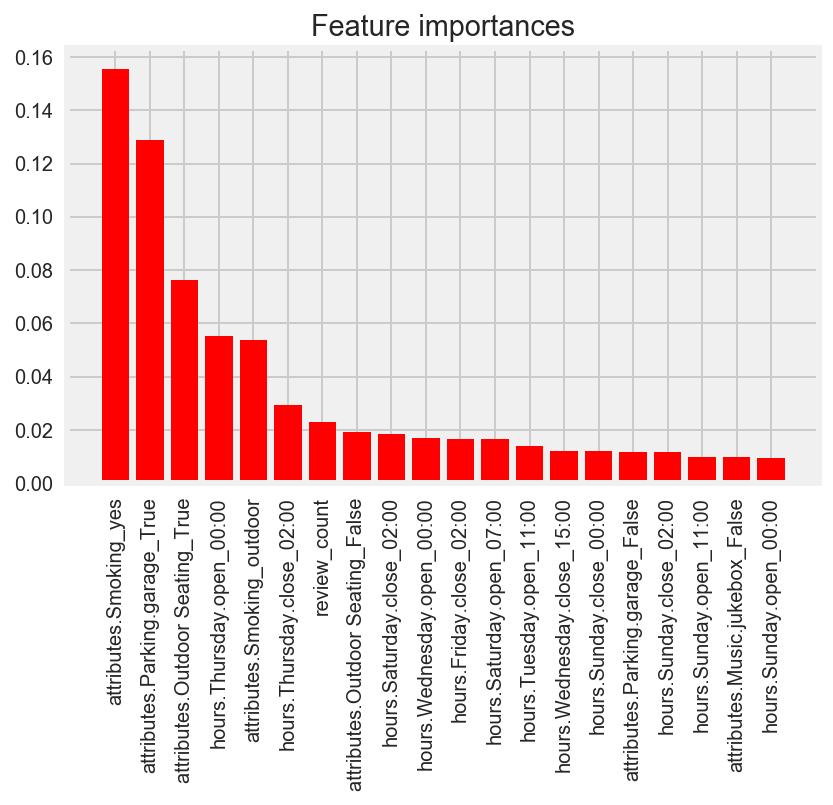

In [27]:
# Plot the feature importances of the forest
feature_importance = zip(rf.feature_importances_,cleaned_business_att.columns)

top_10_predictors = sorted(zip(rf.feature_importances_, cleaned_business_att.columns), reverse=True)[:20]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print predictors

# Plot the feature importances of the forest


plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);


In [28]:
reviews.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
tips.head()

,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print tips.shape, tips.columns
tips.business_id.nunique()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


3752

In [31]:
print reviews.columns, reviews.shape
reviews.columns[0:50]

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       u'20 minutes', u'30 minutes', u'bar food', u'beer selection',
       u'best ve', u'bloody mary', u'bottle service', u'chicken waffles',
       u'customer service', u'dance floor', u'decided try', u'definitely come',
       u'definitely recommend', u'didn want', u'don know', u'don like',
       u'don think', u'don want', u'eggs benedict', u'fast food', u'feel like',
       u'felt like', u'fish chips', u'food amazing', u'food came',
       u'food delicious', u'food good', u'food great', u'food just',
       u'food service', u'french fries', u'french toast', u'friday night',
       u'fried chicken', u'friendly staff', u'good food', u'good place',
       u'good service', u'good thing', u'good time'],
      dtype='object')

In [32]:
print users.shape, users.columns
users.columns

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')

In [33]:
print checkins.shape, checkins.columns
checkins.head()

(214299, 3) Index([u'business_id', u'variable', u'value'], dtype='object')


,business_id,variable,value
0,SG_gEmEXL4ID6RAEinC5Bg,checkin_info.9-0,1.0
1,45puCRQ6Vh_IIAy7kkfFDQ,checkin_info.9-0,1.0
2,P7wKlbSRsoRrfH3DFOY08A,checkin_info.9-0,1.0
3,qsWxbgQwuomXvMseg23DGg,checkin_info.9-0,1.0
4,VCQ3VvnVRhibTT8J61xWkw,checkin_info.9-0,1.0


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [34]:
col_names = tips.columns

In [35]:
tips['service great'] = tips['service great'].map(lambda x: 1 if x>=1 else 0)

In [36]:
service_lst = []
for item in col_names:
    if 'service' in item:
        service_lst.append(item)

In [37]:
no_service_lst = []
for item in col_names:
    if not 'service' in item:
        no_service_lst.append(item)
no_service_lst.append('bottle service')

In [38]:
service_tips = tips.groupby(['user_id'])[service_lst].sum().reset_index()
service_tips = service_tips.drop('bottle service',axis=1)
service_tips['total_comment'] = service_tips.sum(axis=1,numeric_only=True)
float(len(service_tips[service_tips.total_comment > 0]))/len(tips.user_id.unique())

0.09717549266306652

In [39]:
no_service_tips = tips.groupby(['user_id'])[no_service_lst].sum().reset_index()
no_service_tips['total_comment'] = no_service_tips.sum(axis=1,numeric_only=True)
len(no_service_tips[no_service_tips.total_comment > 0])/float(len(tips.user_id.unique()))

0.3811529870790806

In [40]:
test = pd.merge(reviews,tips,on='user_id')
test.shape

(1030290, 211)

In [41]:
test = test.groupby(['user_id']).sum().reset_index()

In [42]:
col_names_total = test.columns

In [43]:
service_lst_total = []
for item in col_names_total:
    if 'service' in item:
        service_lst_total.append(item)

In [44]:
test.head()

,user_id,votes.cool,votes.funny,stars,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,...,service good_y,service great_y,slow service,staff friendly_y,staff great,steak eggs,super friendly_y,sweet potato_y,velvet pancakes,worth wait
0,--2QZsyXGz1OhiD4-0FQLQ,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--4fX3LBeXoE88gDTK6TKQ,3,4,17,12,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
2,--65q1FpAL_UQtVZ2PTGew,2775,1813,4144,3145,0,0,0,0,37,...,0,0,0,0,0,0,0,0,0,0
3,--FpxrGL-a82dkgrWZLn5Q,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--JC6ri9lh1-tazGOFA3yg,0,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
service_total = test.groupby(['user_id'])[service_lst_total].sum().reset_index()
service_total['total_comment'] = service_total.sum(axis=1,numeric_only=True)
float(len(service_total[service_tips.total_comment > 0]))/len(test.user_id.unique())

/Users/Yemre/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


0.0975511681209538

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [46]:
#users['elite_class'] = users.elite.map(lambda x : len(x.split(",")) if len(x)>2 else 0)
users['elite_class'] = users.elite.map(lambda x : 1 if len(x)>2 else 0)

In [47]:
users = users.drop(['elite','user_id','name','yelping_since'],axis=1)

In [48]:
users = users.fillna(0)

In [49]:
X = users[users.columns[:-1]].values
y = users.elite_class.values

In [50]:
X = mms.fit_transform(X)

In [51]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, y, test_size = .33, random_state = 3)

lasso = LogisticRegression(penalty="l1")

lasso.fit(Xl_train,yl_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
lasso.score(Xl_test,yl_test)
cross_val_score(lasso,X,y,cv=5)

array([ 0.94487206,  0.9442133 ,  0.94289578,  0.94254508,  0.9399792 ])

In [53]:
rf = RandomForestClassifier(n_estimators=5, max_depth=5, min_samples_split=2, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 3)
rf.fit(X_train,y_train)
print rf.score(X_test,y_test)
scores = cross_val_score(rf, X, y, cv = 5)
scores

0.957300159704


array([ 0.95600166,  0.95627904,  0.95679911,  0.95839112,  0.95495839])

['compliments.writer', 'compliments.cool', 'compliments.note', 'compliments.more', 'review_count', 'votes.useful', 'compliments.plain', 'compliments.hot', 'votes.cool', 'fans']


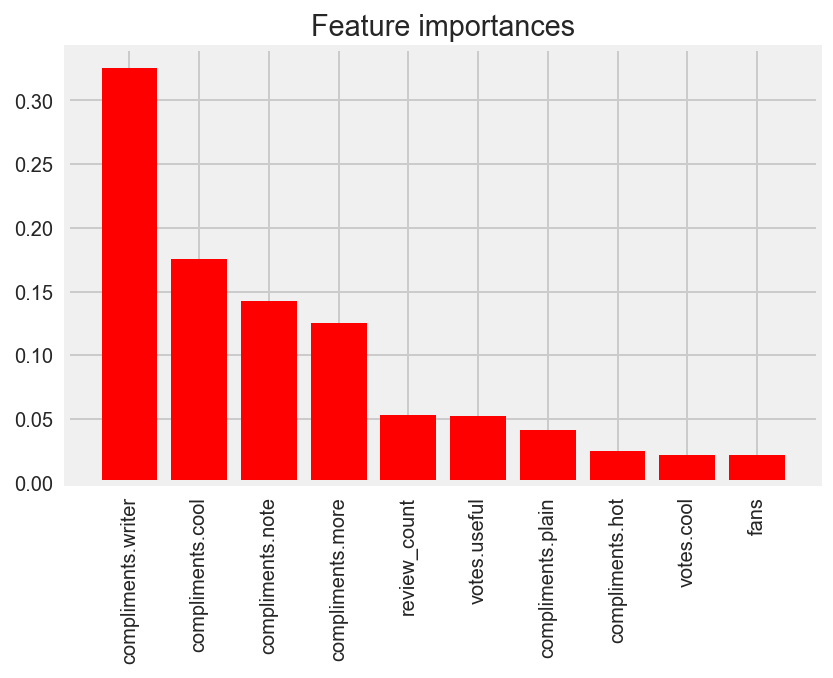

In [55]:
feature_importance = zip(rf.feature_importances_,users[users.columns[:-1]])

feature_importance

top_10_predictors = sorted(zip(rf.feature_importances_, users[users.columns[:-1]]), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print predictors

# Plot the feature importances of the forest


plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);



In [56]:
col_users = users.columns
col_users

Index([u'compliments.plain', u'review_count', u'compliments.cute',
       u'compliments.writer', u'fans', u'compliments.note', u'compliments.hot',
       u'compliments.cool', u'compliments.profile', u'average_stars',
       u'compliments.more', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful',
       u'elite_class'],
      dtype='object')

In [57]:
col_no_count = []

for item in col_users:
    if ('review' in item or 'votes' in item or 'compliments' in item)!= True:
        col_no_count.append(item)

users_no_count = users[col_no_count]

In [58]:
X = users_no_count[users_no_count.columns[:-1]].values
y = users_no_count.elite_class.values

In [59]:
rf = RandomForestClassifier(n_estimators=5, max_depth=5, min_samples_split=2, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 3)
rf.fit(X_train,y_train)
print rf.score(X_test,y_test)
scores = cross_val_score(rf, X, y, cv = 5)
scores

0.943809363705


array([ 0.94390126,  0.9416476 ,  0.94254906,  0.94483356,  0.94303051])

['fans', 'average_stars']


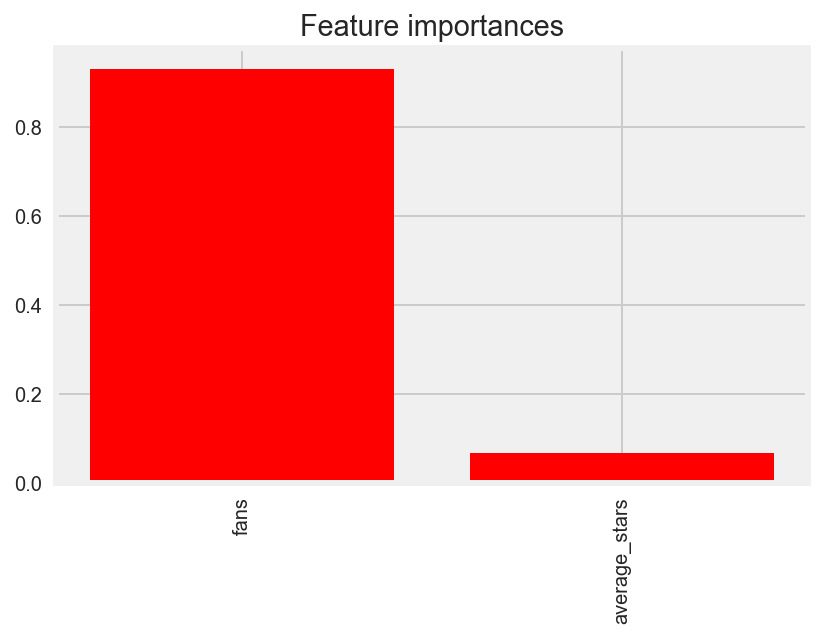

In [60]:
feature_importance = zip(rf.feature_importances_,users[users_no_count.columns[:-1]])

feature_importance

top_10_predictors = sorted(zip(rf.feature_importances_, users_no_count[users_no_count.columns[:-1]]), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print predictors

# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

In [61]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, y, test_size = .33, random_state = 3)

lasso = LogisticRegression(penalty="l1")

lasso.fit(Xl_train,yl_train)

print lasso.score(Xl_test,yl_test)
cross_val_score(lasso,X,y,cv=5)

0.936076321762


array([ 0.93731364,  0.93582276,  0.93641218,  0.93446602,  0.93307906])

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

### Create a new feature based on service and everything else
### Try to predict weather a user will favor service or everything else
### Then when searched for a place show the result based on the favor of the user
### Come back when done

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

In [75]:
X = business_copy.drop(['name', 'latitude', 'longitude', 'neighborhoods', 'categories'], axis = 1)
y = business_copy.city

X_wide = X.pivot(index='business_id', columns='variable', values = 'value')
X_wide = pd.DataFrame(X_wide)

In [86]:
X_wide = X_wide.astype(bool)

In [87]:
X_wide = X_wide.astype(int)


In [122]:
col = X_wide.columns
count = []
for item in col:
    if not 'hours' in item:
        count.append(item)
col_cat = count
X_wide = X_wide[col_cat]
X_wide.columns

Index([u'attributes.Accepts Credit Cards', u'attributes.Accepts Insurance',
       u'attributes.Ages Allowed', u'attributes.Alcohol',
       u'attributes.Ambience.casual', u'attributes.Ambience.classy',
       u'attributes.Ambience.divey', u'attributes.Ambience.hipster',
       u'attributes.Ambience.intimate', u'attributes.Ambience.romantic',
       u'attributes.Ambience.touristy', u'attributes.Ambience.trendy',
       u'attributes.Ambience.upscale', u'attributes.Attire',
       u'attributes.BYOB', u'attributes.BYOB/Corkage',
       u'attributes.By Appointment Only', u'attributes.Caters',
       u'attributes.Coat Check', u'attributes.Corkage', u'attributes.Delivery',
       u'attributes.Dietary Restrictions.dairy-free',
       u'attributes.Dietary Restrictions.gluten-free',
       u'attributes.Dietary Restrictions.halal',
       u'attributes.Dietary Restrictions.kosher',
       u'attributes.Dietary Restrictions.soy-free',
       u'attributes.Dietary Restrictions.vegan',
       u'attrib

In [89]:
X_wide.to_csv(path_or_buf='/Users/Yemre/Desktop/DSI-SF-5_2_Local/projects/project-4/wide.csv')

In [142]:
#y1 = X_wide['attributes.Wheelchair Accessible']

In [91]:
col_for_predict = [u'attributes.Accepts Credit Cards', u'attributes.Accepts Insurance',
       u'attributes.Ages Allowed', u'attributes.Alcohol',
       u'attributes.Ambience.casual', u'attributes.Ambience.classy',
       u'attributes.Ambience.divey', u'attributes.Ambience.hipster',
       u'attributes.Ambience.intimate', u'attributes.Ambience.romantic',
       u'attributes.Ambience.touristy', u'attributes.Ambience.trendy',
       u'attributes.Ambience.upscale', u'attributes.Attire',
       u'attributes.BYOB', u'attributes.BYOB/Corkage',
       u'attributes.By Appointment Only', u'attributes.Caters',
       u'attributes.Coat Check', u'attributes.Corkage', u'attributes.Delivery',
       u'attributes.Dietary Restrictions.dairy-free',
       u'attributes.Dietary Restrictions.gluten-free',
       u'attributes.Dietary Restrictions.halal',
       u'attributes.Dietary Restrictions.kosher',
       u'attributes.Dietary Restrictions.soy-free',
       u'attributes.Dietary Restrictions.vegan',
       u'attributes.Dietary Restrictions.vegetarian',
       u'attributes.Dogs Allowed', u'attributes.Drive-Thru',
       u'attributes.Good For Dancing', u'attributes.Good For Groups',
       u'attributes.Good For.breakfast', u'attributes.Good For.brunch',
       u'attributes.Good For.dessert', u'attributes.Good For.dinner',
       u'attributes.Good For.latenight', u'attributes.Good For.lunch',
       u'attributes.Good for Kids', u'attributes.Happy Hour',
       u'attributes.Has TV', u'attributes.Music.background_music',
       u'attributes.Music.dj', u'attributes.Music.jukebox',
       u'attributes.Music.karaoke', u'attributes.Music.live',
       u'attributes.Music.video', u'attributes.Noise Level',
       u'attributes.Open 24 Hours', u'attributes.Order at Counter',
       u'attributes.Outdoor Seating', u'attributes.Parking.garage',
       u'attributes.Parking.lot', u'attributes.Parking.street',
       u'attributes.Parking.valet', u'attributes.Parking.validated',
       u'attributes.Price Range', u'attributes.Smoking',
       u'attributes.Take-out', u'attributes.Takes Reservations',
       u'attributes.Waiter Service',
       u'attributes.Wi-Fi', u'open']

In [92]:
X_wide = X_wide[col_for_predict]

In [95]:
X_wide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4132 entries, --jFTZmywe7StuZ2hEjxyA to zwHM6hz8swKIG-4-BSKMPA
Data columns (total 63 columns):
attributes.Accepts Credit Cards                4132 non-null int64
attributes.Accepts Insurance                   4132 non-null int64
attributes.Ages Allowed                        4132 non-null int64
attributes.Alcohol                             4132 non-null int64
attributes.Ambience.casual                     4132 non-null int64
attributes.Ambience.classy                     4132 non-null int64
attributes.Ambience.divey                      4132 non-null int64
attributes.Ambience.hipster                    4132 non-null int64
attributes.Ambience.intimate                   4132 non-null int64
attributes.Ambience.romantic                   4132 non-null int64
attributes.Ambience.touristy                   4132 non-null int64
attributes.Ambience.trendy                     4132 non-null int64
attributes.Ambience.upscale                    4132 non

In [98]:

X1 = mms.fit_transform(X1)

In [99]:
y2 = X_wide['attributes.Music.live']

In [102]:
col_imbalanced = [u'attributes.Accepts Credit Cards', u'attributes.Accepts Insurance',
       u'attributes.Ages Allowed', u'attributes.Alcohol',
       u'attributes.Ambience.casual', u'attributes.Ambience.classy',
       u'attributes.Ambience.divey', u'attributes.Ambience.hipster',
       u'attributes.Ambience.intimate', u'attributes.Ambience.romantic',
       u'attributes.Ambience.touristy', u'attributes.Ambience.trendy',
       u'attributes.Ambience.upscale', u'attributes.Attire',
       u'attributes.BYOB', u'attributes.BYOB/Corkage',
       u'attributes.By Appointment Only', u'attributes.Caters',
       u'attributes.Coat Check', u'attributes.Corkage', u'attributes.Delivery',
       u'attributes.Dietary Restrictions.dairy-free',
       u'attributes.Dietary Restrictions.gluten-free',
       u'attributes.Dietary Restrictions.halal',
       u'attributes.Dietary Restrictions.kosher',
       u'attributes.Dietary Restrictions.soy-free',
       u'attributes.Dietary Restrictions.vegan',
       u'attributes.Dietary Restrictions.vegetarian',
       u'attributes.Dogs Allowed', u'attributes.Drive-Thru',
       u'attributes.Good For Dancing', u'attributes.Good For Groups',
       u'attributes.Good For.breakfast', u'attributes.Good For.brunch',
       u'attributes.Good For.dessert', u'attributes.Good For.dinner',
       u'attributes.Good For.latenight', u'attributes.Good For.lunch',
       u'attributes.Good for Kids', u'attributes.Happy Hour',
       u'attributes.Has TV', u'attributes.Music.background_music',
       u'attributes.Music.dj', u'attributes.Music.jukebox',
       u'attributes.Music.karaoke', 
       u'attributes.Music.video', u'attributes.Noise Level',
       u'attributes.Open 24 Hours', u'attributes.Order at Counter',
       u'attributes.Outdoor Seating', u'attributes.Parking.garage',
       u'attributes.Parking.lot', u'attributes.Parking.street',
       u'attributes.Parking.valet', u'attributes.Parking.validated',
       u'attributes.Price Range', u'attributes.Smoking',
       u'attributes.Take-out', u'attributes.Takes Reservations',
       u'attributes.Waiter Service',
       u'attributes.Wi-Fi', u'open']

In [209]:
X2 = X_wide[col_imbalanced]

In [210]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X1, y1, test_size = .33, random_state = 3)

lasso = LogisticRegression(penalty="l1")

lasso.fit(Xl_train,yl_train)

print lasso.score(Xl_test,yl_test)
cross_val_score(lasso,X1,y1,cv=5)

0.725073313783


array([ 0.72826087,  0.71912833,  0.72276029,  0.7409201 ,  0.74818402])

In [211]:
pd.crosstab(yl_test,yl_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,191,550,741
1,169,454,623
All,360,1004,1364


In [212]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
FPR = dict()
TPR = dict()
ROC_AUC = dict()
FPR[1], TPR[1], _  = metrics.roc_curve(yl_test, probabilities[:, 1])
TPR

{1: array([ 0.00160514,  0.01284109,  0.01284109,  0.01926164,  0.02086677,
         0.02086677,  0.02728732,  0.03049759,  0.03691814,  0.04173355,
         0.11075441,  0.11235955,  0.17335474,  0.18298555,  0.18298555,
         0.19422151,  0.19422151,  0.19422151,  0.19582665,  0.19582665,
         0.19743178,  0.19743178,  0.19903692,  0.19903692,  0.20064205,
         0.20224719,  0.20385233,  0.20385233,  0.20545746,  0.20866774,
         0.20866774,  0.21669342,  0.2247191 ,  0.22632424,  0.23756019,
         0.25361156,  0.25361156,  0.25682183,  0.25842697,  0.27608347,
         0.28571429,  0.28731942,  0.2905297 ,  0.2905297 ,  0.29373997,
         0.31139647,  0.31300161,  0.31300161,  0.31300161,  0.3611557 ,
         0.37239165,  0.37239165,  0.37399679,  0.37560193,  0.37560193,
         0.40770465,  0.40770465,  0.40930979,  0.41091493,  0.41091493,
         0.41091493,  0.41091493,  0.41252006,  0.4141252 ,  0.4141252 ,
         0.41573034,  0.41573034,  0.41573034,  

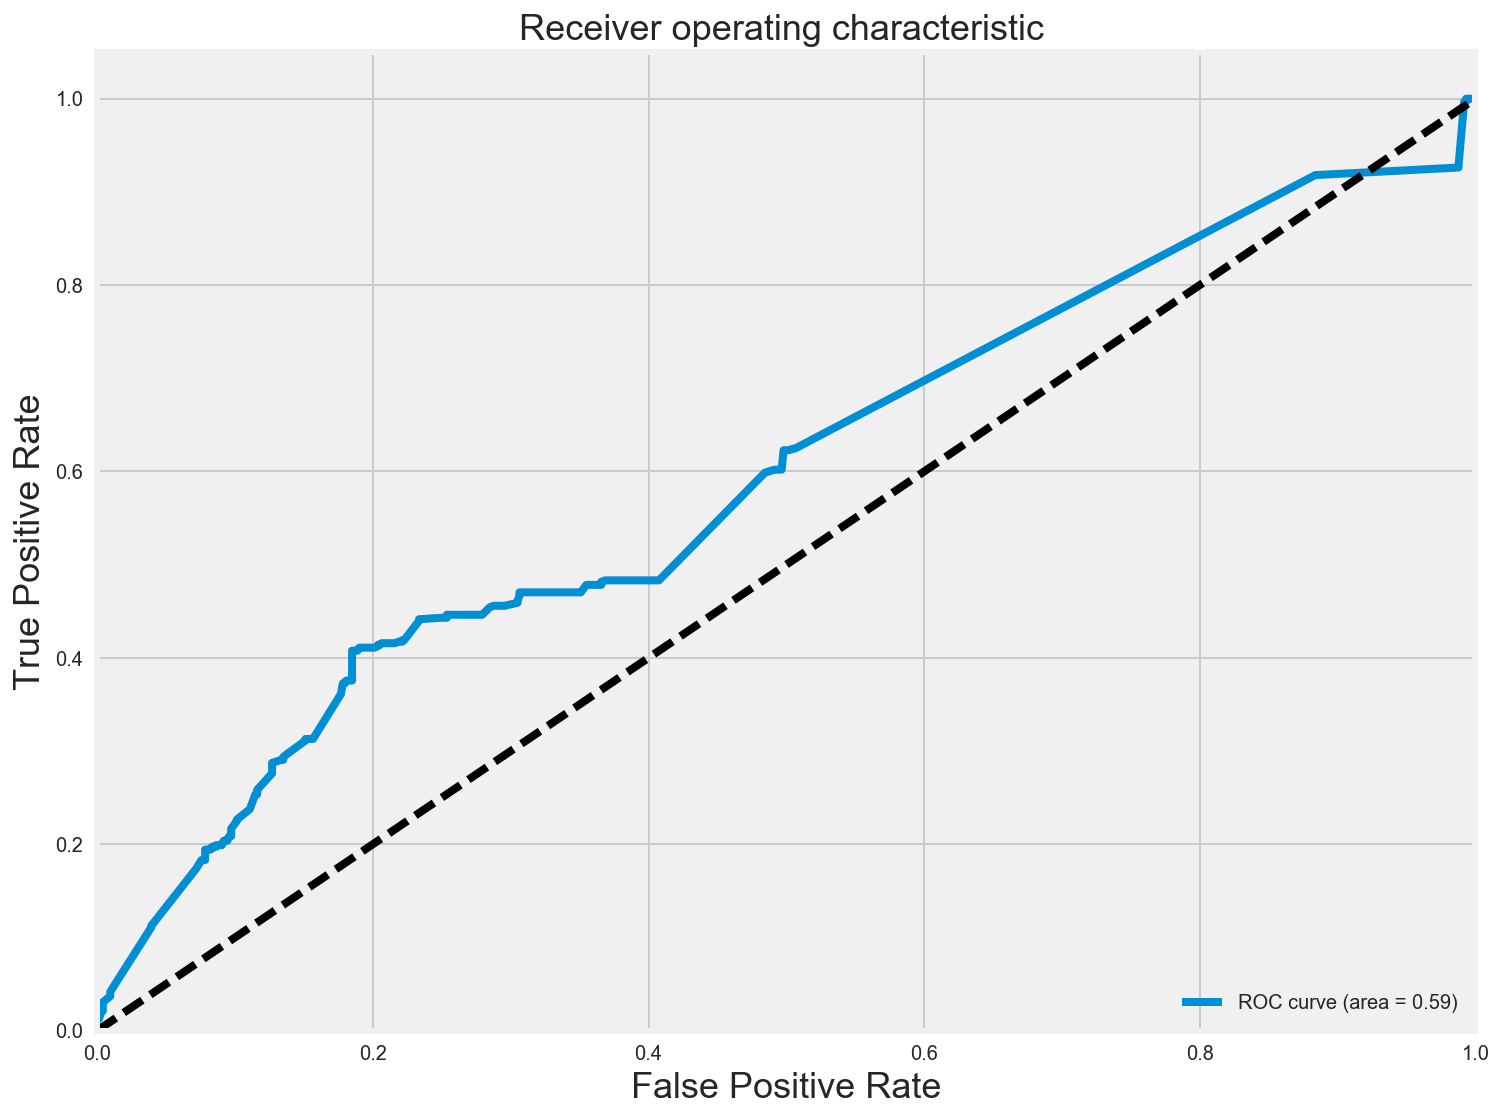

In [213]:
ROC_AUC[1] = metrics.auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic ', fontsize=18)
plt.legend(loc="lower right")
plt.show()

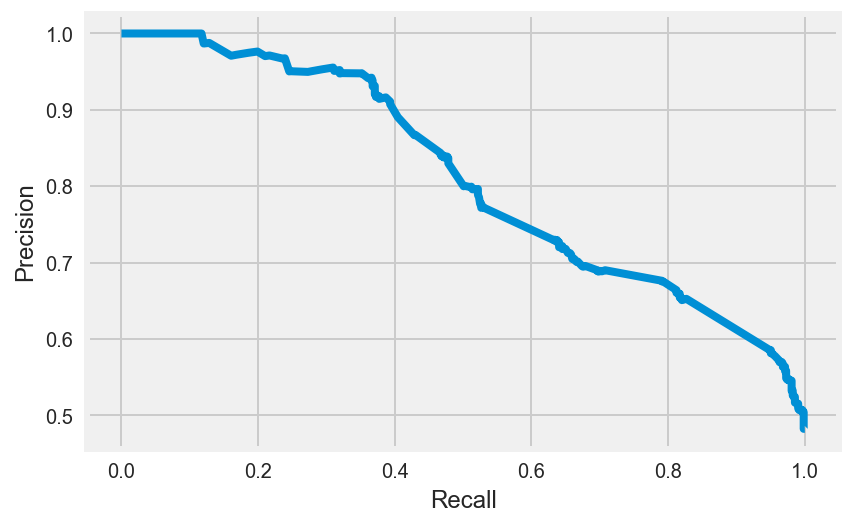

In [214]:
precision, recall, thresholds = precision_recall_curve(yl_test,probas_pred=lasso.decision_function(Xl_test))

plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Second Model

In [161]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X2, y2, test_size = .33, random_state = 3)

lasso = LogisticRegression(penalty="l1")

lasso.fit(Xl_train,yl_train)
probabilities = lasso.predict_proba(Xl_test)
y1_hat = lasso.predict(Xl_test)
print lasso.score(Xl_test,yl_test)
cross_val_score(lasso,X2,y2,cv=5)
lasso.decision_function(Xl_test)

0.986803519062


array([-4.58294882, -5.83930267, -5.58819921, ..., -3.45291527,
       -3.01291685,  8.71482657])

In [162]:
pd.crosstab(yl_test,yl_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)


Predicted,0,1,All
Actual,,,
0,302,848,1150
1,58,156,214
All,360,1004,1364


In [166]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
FPR = dict()
TPR = dict()
ROC_AUC = dict()
FPR[1], TPR[1], _  = metrics.roc_curve(yl_test, probabilities[:, 1])
TPR

{1: array([ 0.0046729 ,  0.03738318,  0.04205607,  0.06542056,  0.07476636,
         0.09345794,  0.10280374,  0.14018692,  0.15420561,  0.45794393,
         0.46261682,  0.75233645,  0.79439252,  0.80373832,  0.8364486 ,
         0.84579439,  0.89719626,  0.90654206,  0.92056075,  0.92056075,
         0.92990654,  0.92990654,  0.92990654,  0.92990654,  0.95794393,
         0.95794393,  0.95794393,  0.95794393,  0.95794393,  0.98598131,
         0.99065421,  0.99065421,  0.99065421,  0.99065421,  0.99065421,
         0.99065421,  0.99065421,  0.99065421,  0.99065421,  0.99065421,
         0.99065421,  0.99065421,  0.99065421,  0.99065421,  0.99065421,
         0.99065421,  0.99065421,  0.99065421,  0.99065421,  0.99065421,
         0.99065421,  0.99065421,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  

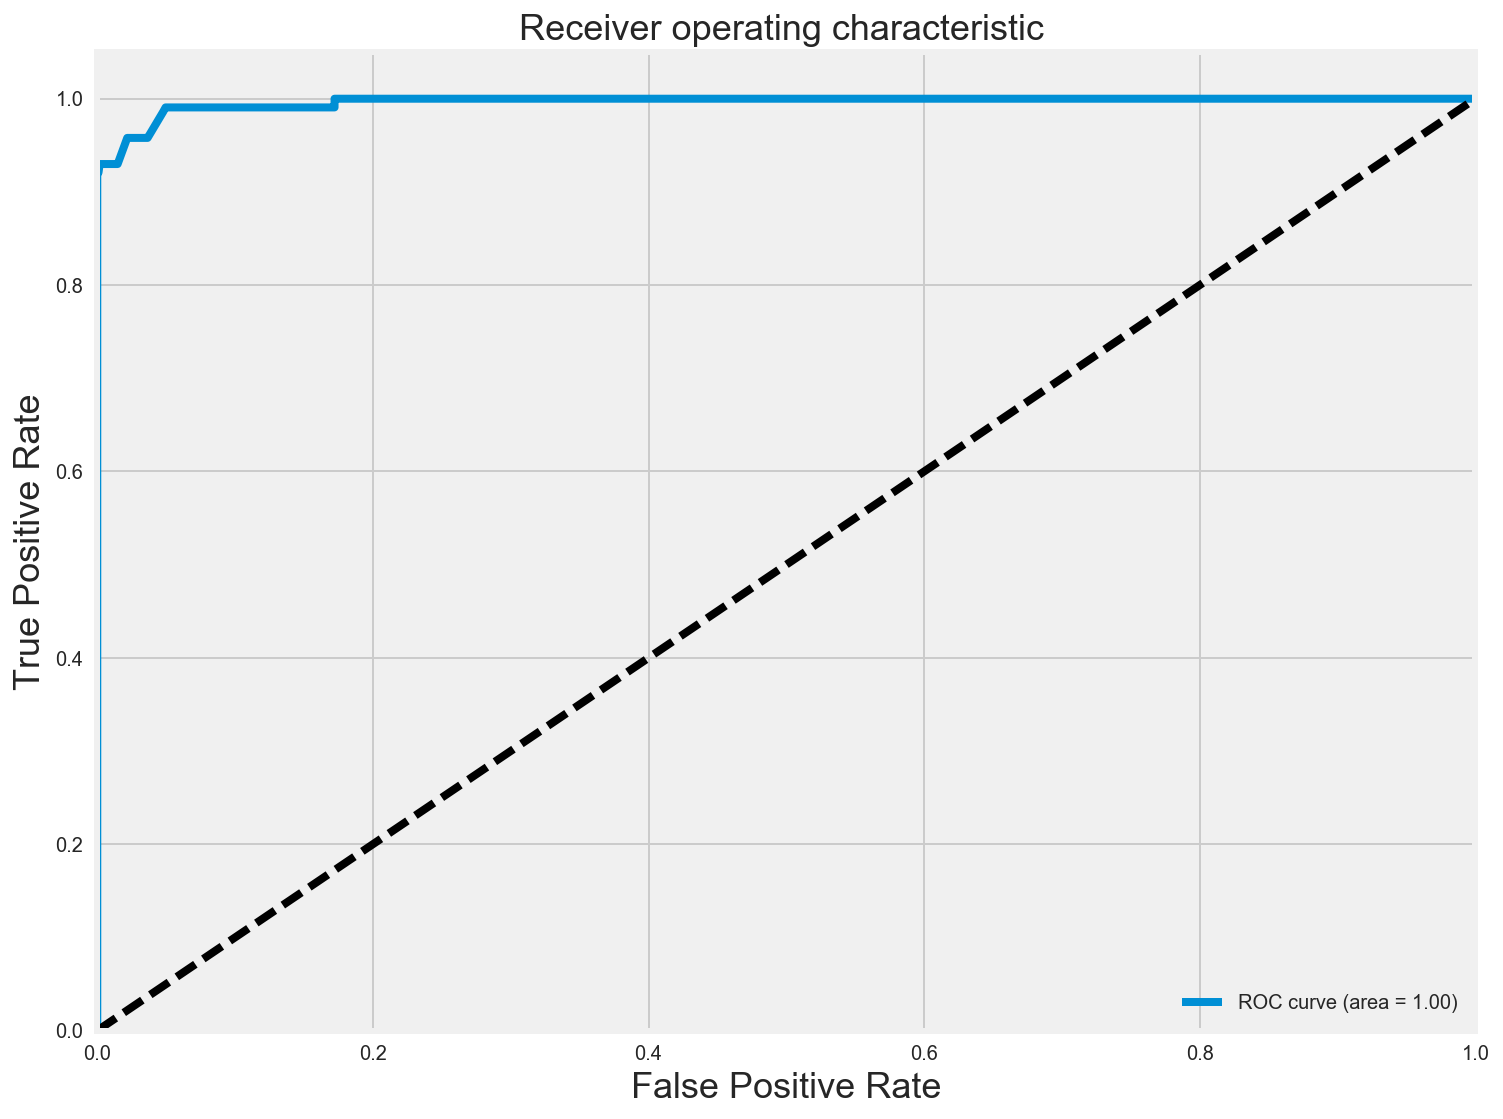

In [168]:


# [insert explanation of this section]
#FPR[1], TPR[1], _ = roc_curve(y, probabilities[:, 1])
ROC_AUC[1] = metrics.auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic ', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [199]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve

y2 = label_binarize(y2, classes=[0, 1])
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = .33, random_state = 3)
# Run classifier
#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                 random_state=random_state))
y_score = lasso.fit(X_train, y_train).decision_function(X_test)

AttributeError: 'LogisticRegression' object has no attribute 'p'

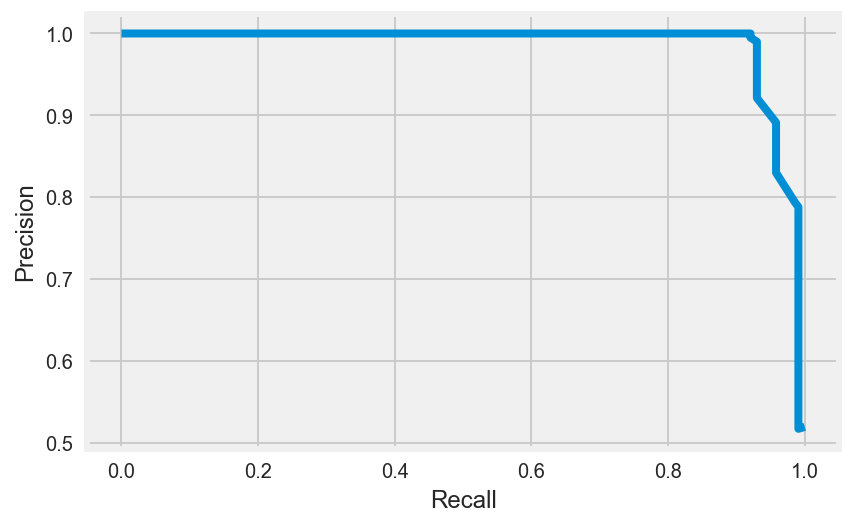

In [208]:
precision, recall, thresholds = precision_recall_curve(yl_test,probas_pred=lasso.decision_function(Xl_test))

plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

In [109]:
from sklearn.datasets import fetch_mldata

In [141]:
#mnist = fetch_mldata('MNIST original')

In [ ]:
### Counldnt load the data, my pc was running it for ever 
#and got really hot 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [115]:
def bin_search(lst,num):
    
    if not lst:
        
        mid_point = len(lst)/2
            
        if lst[mid_point] == num:
            return True
        elif lst[mid_point] < num:
            return bin_search(lst[:mid_point],num)
        elif lst[mid_point] > num:
            return bin_search(lst[mid_point+1:],num)
#Complexity is O(longn)

In [117]:
def merge(left, right):
    if not len(left) or not len(right):
        return left or right

    result = []
    i, j = 0, 0
    while (len(result) < len(left) + len(right)):
        if left[i] < right[j]:
            result.append(left[i])
            i+= 1
        else:
            result.append(right[j])
            j+= 1
        if i == len(left) or j == len(right):
            result.extend(left[i:] or right[j:])
            break 

    return result

def mergesort(list):
    if len(list) < 2:
        return list

    middle = len(list)/2
    left = mergesort(list[:middle])
    right = mergesort(list[middle:])

    return merge(left, right)



In [140]:
def close_point(arr1,arr2,num):
    pair = []
    minn = 9999
    for item1 in arr1:
        for item2 in arr2:
            if abs(item1+item2-num ) < minn:
                minn = abs(item1+item2-num)
                pair = [item1,item2]
    return minn,pair

arr1 = [1,3,6,7,9]
arr2 = [4,66,77,99]

print close_point(arr1,arr2,2)

(3, [1, 4])


### Complexity is O(n^2)

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?

## %80

- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?

## %25


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 

### I would use the dart example! If they hit the middle and they are all close thats low var and bias. If they hit off the middle but all close, thats high bias and low var. Close to middle but all over the place low bias high var. Far away from the middle and all over, high bias and high var.

### If we are getting wrong regardless the dataset then high bias, but it is good for one data set it is low var.

- Explain why cross-validation is important. 

### To see if our model var overfitting

- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 

### To penalize the wrong estiamtion. Lasso would get rid of some of the fature and ridge wouldnt but try to optimize. We shouldnt really use lasso if we dont have much feature

- What are the loss functions associated with linear regression, logistic regression, and KNN? 

### Linear Regression, we have the residual and logistic, we have the mean of the sum of the yi*log(pi) + (1-yi)*log(1-pi). KNN we dont have one other then minimazing the distance function to determine the number if neighbour.

- Can you give examples of feature engineering on datasets you have worked with? 

### To multiply num of bedrooms with number of bathroom would increase the emphasis on those features and would be helpful to get a better model trained